In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
import matplotlib.pyplot as plot
# we can use the LabelEncoder to encode the gender feature
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# importing two different imputation methods that take into consideration all the features when predicting the missing values
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier

# oversample the minority class using SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

np.random.seed(42)

##### Data loading and exploratory analysis (18/100)

dataframe shape:
(615, 14)

dataframe columns:
Index(['Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA',
       'GGT', 'PROT', 'split', 'category'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       615 non-null    int64  
 1   Sex       615 non-null    object 
 2   ALB       614 non-null    float64
 3   ALP       597 non-null    float64
 4   ALT       614 non-null    float64
 5   AST       615 non-null    float64
 6   BIL       615 non-null    float64
 7   CHE       615 non-null    float64
 8   CHOL      605 non-null    float64
 9   CREA      615 non-null    float64
 10  GGT       615 non-null    float64
 11  PROT      614 non-null    float64
 12  split     615 non-null    object 
 13  category  615 non-null    int64  
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB
dataframe info

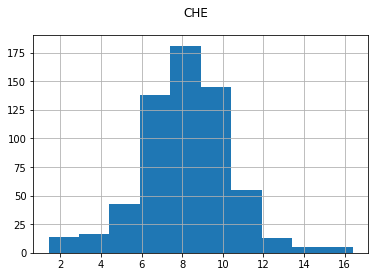

In [20]:
# load the dataset (1)
df = pd.read_csv('./data/hcv_data_split.csv')

# print the dimensionality of the dataframe (1)
print(f"dataframe shape:\n{df.shape}\n")

# print the names of the columns that can be used as features when training the machine learning model (1)
print(f"dataframe columns:\n{df.columns}\n")

# print the different data types that can be identified from the entire dataset (1)
print(f"dataframe info:\n{df.info()}\n")

# print the gender distribution in the complete dataset(i.e., the number of male and female individuals) (1)
print(f"value counts:\n{df['Sex'].value_counts()}\n")

# print the class distribution of the entire dataset (1)
print(f"Class Distribution:\n{df['category'].value_counts() / len(df)}\n")

# print the median age of patients in the dataset having the hepatitis C infection (1.5)
print(f"Median Age w/ Hepatitis C:\n{df.groupby('category').mean()['Age'][1]}\n")


# print the mean age of individuals in the dataset who does not have hepatitis C infection(i.e., the control group) (1.5)
print(f"Median Age w/o Hepatitis C:\n{df.groupby('category').mean()['Age'][0]}\n")


# split the dataset into train and test based on the field "split" (0.5 + 0.5)
data_train = df[df['split'] == 'train']
data_test = df[df['split'] == 'test']

print('+++++++')
print(data_train)


print(data_test)

# print the dimensionality of the test dataset (0.5)
print(f"training data shape:\n{data_train.shape}\n")

# print the dimensionality of the training dataset (0.5)
print(f"testing data shape:\n{data_test.shape}\n")

# print the proportional distribution of the classes to identify whether or not the classes are equally(or closer) distributed between the train and test datasets (1 + 1)


# analyze the distribution of the individual features(i.e., by using the complete dataset) and plot a feature that has a rough approximation of a Gaussian distribution (2)
fig = plot.figure()
fig.suptitle("CHE", fontsize=12)
df['CHE'].hist()

# TO Print All columns
# for col in df:
#   fig = plot.figure()
#   fig.suptitle(col, fontsize=12)
#   df[col].hist()
# print histogram of the income categories


# identify features that represent a notable correlation (i.e., either positive or negative correlation below or above -0.5 and 0.5) (3)

corr_matrix = df.corr().abs()
correlations = corr_matrix.unstack()
highCorrelations = correlations.sort_values(kind="quicksort", ascending=False)[correlations > 0.5 ]# Figure out how to filter wihtout the < 1??
print(highCorrelations)




##### Model development (64/100)

In [21]:
# separate the features and the labels to be used in model development (2)
labels = data_train["category"].copy()
data_train = data_train.drop("category", axis=1) 

# print the dimensionality of the dataset and the labels (0.5 + 0.5)
print(f"dataset shape:\n{data_train.shape}\n")
print(f"labels shape:\n{labels.shape}\n")

# check for missing values in the training dataset and print how many rows can be identified with the missing values (1)

sample_incomplete_rows = data_train[data_train.isnull().any(axis=1)].head()
print(sample_incomplete_rows)
print(f'Incomplete Rows Identified: {sample_incomplete_rows.shape[0]}')


# data imputation
# given the task in predicting individuals with hepatitis C infection, select two of the most appropriate imputation strategies to fill the missing values and briefly explain why you have selected the particular strategies in a markdown cell below the current cell (3)
imputer_simple = SimpleImputer(strategy='median')
imputer_knn = KNNImputer(n_neighbors=5)
imputer_iter = IterativeImputer(max_iter=10)

numeric_training_data = data_train.drop("Sex", axis=1)
numeric_training_data = numeric_training_data.drop("split", axis=1)

print("---------------[ Simple Imputer ]---------------")
imputer_simple.fit(numeric_training_data)
print(imputer_simple.statistics_)
print("---------------[ knn Imputer ]---------------")
imputer_knn.fit(numeric_training_data)
print("---------------[ iter Imputer ]---------------")
imputer_iter.fit(numeric_training_data)

print(numeric_training_data.median().values)
# Something here

# print the rows before and after being imputed with the two selected strategies (5)
print("---------------[ Before Imputation ]---------------")
print(numeric_training_data.loc[sample_incomplete_rows.index.values])
print("---------------[ Simple Imputation ]---------------")
input_a = imputer_simple.transform(numeric_training_data)
simple_imputed_data = pd.DataFrame(input_a, columns=numeric_training_data.columns, index=numeric_training_data.index)
print(simple_imputed_data.loc[sample_incomplete_rows.index.values])
print("---------------[ knn Imputation ]---------------")
input_b = imputer_knn.transform(numeric_training_data)
knn_imputed_data = pd.DataFrame(input_b, columns=numeric_training_data.columns, index=numeric_training_data.index)
print(knn_imputed_data.loc[sample_incomplete_rows.index.values])

# indicate the encoding strategy that is more appropriate given the categorical feature 'Sex' and briefly explain why you selected one strategy over the other (i.e., either OrdinalEncoder or OneHotEncoder) in the markdown cell mentioned below (3)

dataset shape:
(430, 13)

labels shape:
(430,)

    Age Sex   ALB   ALP    ALT    AST   BIL    CHE  CHOL  CREA   GGT  PROT  \
4    59   f  36.0   NaN  100.0   80.0  12.0   9.07   5.3  67.0  34.0  68.0   
6    32   f  47.4  52.5   19.1   17.1   4.6  10.19   NaN  63.0  23.0  72.2   
8    50   m  42.0   NaN  258.0  106.0  15.0   8.74   4.7  77.0  80.0  84.0   
42   46   f  42.9  55.1   15.2   29.8   3.6   8.37   NaN  61.0  29.0  71.9   
59   49   m  39.0   NaN  118.0   62.0  10.0   7.28   3.5  72.0  74.0  81.0   

    split  
4   train  
6   train  
8   train  
42  train  
59  train  
Incomplete Rows Identified: 5
---------------[ Simple Imputer ]---------------
[47.    41.9   66.2   22.    25.55   7.15   8.265  5.25  77.    22.85
 72.05 ]
---------------[ knn Imputer ]---------------
---------------[ iter Imputer ]---------------
[47.    41.9   66.2   22.    25.55   7.15   8.265  5.25  77.    22.85
 72.05 ]
---------------[ Before Imputation ]---------------
    Age   ALB   ALP    ALT   

Data imputations explanation?

### Categorical data encoding strategy explanation?

We opted to use OneHotEncoder as there is no relationship between the categories. Using the OrdinalEncoder is preferable for ordinal categories - when the values have some connection between each other. The Sex category is binary, and there is no relation between the  discrete values

In [38]:
# select one of the scaling strategies and briefly explain why it is essential to scale your features in the markdown cell mentioned below (3)

# create the necessary pipelines and combine the features to be used as the training data for the given algorithm (8)

# creating a pipeline so that you can chain together multiple steps
# NOTE: remember that the output from one step will be an inout to the other
# you can do these steps seperately and combine but Pipelines are more efficient
num_pipeline = Pipeline([
        ('imputer', imputer_iter), # Not sure which imputer is better!
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(numeric_training_data)

cat_attribs = ['Sex']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
        ])
data_prepared = pd.DataFrame(full_pipeline.fit_transform(data_train),columns=data_train.columns, index=data_train.index)
print(data_prepared)

print('========')
print(data_prepared.loc[sample_incomplete_rows.index.values])




          Age       Sex       ALB       ALP       ALT        AST       BIL  \
0    1.099266 -0.689985  0.534796 -0.118323 -0.464372   0.414691 -0.341571   
1   -0.637835 -1.883999  0.592103 -0.855617  0.847381  10.350398 -3.061399   
2    2.739862 -2.200062 -0.711642 -0.121920 -0.229432  -0.149465 -1.768054   
3    0.327221  0.995681  1.738253  1.205209 -0.125013  -0.395941  1.042118   
4    1.099266 -1.006048  0.173322  2.568303  1.493468   0.053193  0.395446   
..        ...       ...       ...       ...       ...        ...       ...   
425 -0.251812  0.837650  0.323474  0.874326 -0.007543   0.058670  0.752066   
426 -0.734340 -0.022742 -0.299745 -0.499558 -0.585106  -0.291873 -0.298776   
427 -1.313374 -0.970930  0.076336 -0.513944 -0.412163  -0.401418  0.752066   
428 -0.734340 -0.479277 -0.919382 -0.172272  2.625752  -0.001579  0.666477   
429  0.906255  0.310879 -0.450177  1.144067  0.100138  -0.204237 -0.688682   

          CHE      CHOL      CREA       GGT  PROT  split  
0   

Why scaling?

In [41]:
# create the following four different models with their default hyperparameter values to be trained using the preprocessed data (0.5 * 4)

# Support Vector Machine
model_support_vector_machine = SVC()

# Decision Trees
model_decision_tree  = DecisionTreeClassifier()

# Random Forests
model_random_forest = RandomForestClassifier()

# Naive Bayes
model_naive_bayes = GaussianNB()

In [46]:
# use sklearn GridSearchCV to train your selected model with hyperparameter tuning
# state briefly the advantage of using cross-validation in the markdown cell below (2)
scoring = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}
# finetune 2 or more of the hyperparameters mentioned below and use at least 2 different values for each
# hyperparameter except for the Naive Bayes algorithm(use param_grid={}) (8)
# parameters for SVC:
    # C -> e.g., 10, 100
    # gamma ->  e.g., 0.001, 0.0001
    # kernel -> 'rbf' or 'linear'
svc_paramaters = [{'C':[10, 100]}, {'gamma': [0.0001, 0.0001]}, {'kernel':['linear']}]
svc_grid_search  = GridSearchCV(model_support_vector_machine, svc_paramaters, cv=5, scoring=scoring, refit='bal_accuracy', return_train_score=True, n_jobs=-1, error_score='raise')

# parameters for DecisionTreeClassifier: 
    # max_depth ->  e.g., 3, 4
    # min_samples_split -> 5, 10
    # min_samples_leaf -> 10, 20
decision_tree_paramaters = [{'max_depth':[3,4]}, {'min_samples_split':[5, 10]}, {'min_samples_leaf':[10, 20]}]
decision_tree_grid_search  = GridSearchCV(model_decision_tree, decision_tree_paramaters, cv=5, scoring=scoring, refit='bal_accuracy', return_train_score=True, n_jobs=-1, error_score='raise')

# parameters for RandomForestClassifier: 
    # n_estimators -> 100, 200
    # max_depth -> 3, 5
    # bootstrap -> True, False
random_forest_paramaters = [{'n_estimators':[100,200]},{'max_depth':[3,5]}, {'bootstrap':[True, False]}]
random_forest_grid_search  = GridSearchCV(model_random_forest, random_forest_paramaters, cv=5, scoring=scoring, refit='bal_accuracy', return_train_score=True, n_jobs=-1, error_score='raise')
# print the best parameters 

naive_bayes_grid_search  = GridSearchCV(model_naive_bayes, {}, cv=5, scoring=scoring, refit='bal_accuracy', return_train_score=True, n_jobs=-1, error_score='raise')


# initialize gridsearch with the required parameters, including the following scoring methods and refit='bal_accuracy' (2)

# fit the training data (0.5)
svc_grid_search.fit(data_prepared, labels)
decision_tree_grid_search.fit(data_prepared, labels)
random_forest_grid_search.fit(data_prepared, labels)
naive_bayes_grid_search.fit(data_prepared, labels)


# print the best parameters (0.5)
print(svc_grid_search.best_params_)
print(decision_tree_grid_search.best_params_)
print(random_forest_grid_search.best_params_)
print(naive_bayes_grid_search.best_params_)


# print the best estimator (0.5)
print(svc_grid_search.best_estimator_)
print(decision_tree_grid_search.best_estimator_)
print(random_forest_grid_search.best_estimator_)
print(naive_bayes_grid_search.best_estimator_)

# print the best score from trained GridSearchCV model (0.5)


{'C': 10}
{'max_depth': 3}
{'bootstrap': False}
{}
SVC(C=10)
DecisionTreeClassifier(max_depth=3)
RandomForestClassifier(bootstrap=False)
GaussianNB()


In [25]:
# print the best parameters 
print(svc_grid_search.best_params_)
# the best estimator
print(svc_grid_search.best_estimator_)

cross_val_results = svc_grid_search.cv_results_  
for params in cross_val_results['params']:
    print(params)

{'C': 10}
SVC(C=10)
{'C': 10}
{'C': 100}
{'gamma': 0.0001}
{'gamma': 0.0001}
{'kernel': 'linear'}


### Why should you use cross-validation? 
Cross Validation helps us to know how good our machine learning model is by using different combinations of training and testing data from the set. In cros validation, the data is divided up into k groups, k-1 of those folds are used to test, and one to train. After completing training with each combination of train/test dat, we can see which setup leads to the most accurate results.


In [26]:
# print the grid search cross-validation results listing the above mentioned evaluation methods (3)
cross_val_results = svc_grid_search.cv_results_
for row in cross_val_results:
  print(row, ':', cross_val_results[row])

mean_fit_time : [0.10886045 0.00358176 0.00305052 0.0030941  0.0026567 ]
std_fit_time : [8.92727269e-02 4.31609227e-04 3.25035097e-05 9.97665500e-05
 1.92762092e-04]
mean_score_time : [0.00319214 0.00294456 0.00262537 0.00267844 0.0021996 ]
std_score_time : [3.23780029e-04 4.09111849e-04 9.46302052e-05 1.69338658e-04
 3.84903592e-05]
param_C : [10 100 -- -- --]
param_gamma : [-- -- 0.0001 0.0001 --]
param_kernel : [-- -- -- -- 'linear']
params : [{'C': 10}, {'C': 100}, {'gamma': 0.0001}, {'gamma': 0.0001}, {'kernel': 'linear'}]
split0_test_accuracy : [0.95348837 0.95348837 0.88372093 0.88372093 0.96511628]
split1_test_accuracy : [0.98837209 0.98837209 0.88372093 0.88372093 0.95348837]
split2_test_accuracy : [0.95348837 0.95348837 0.87209302 0.87209302 0.94186047]
split3_test_accuracy : [0.94186047 0.94186047 0.87209302 0.87209302 0.97674419]
split4_test_accuracy : [0.91860465 0.91860465 0.87209302 0.87209302 0.93023256]
mean_test_accuracy : [0.95116279 0.95116279 0.87674419 0.87674419 

In [27]:
# use a dummy classifier to identify a simple baseline (i.e., a majority class baseline) so that you can compare your prediction results (3)
dummy = DummyClassifier(random_state=42)
dummy.fit(data_prepared, labels)

dummy.predict(data_prepared)
dummy.score(data_prepared, labels)


0.8767441860465116

In [52]:
# prepare the test data to be predicted (2)

testing_data_prepared = full_pipeline.fit_transform(data_test)

# print the dimensionality of the dataset and the labels (0.5 + 0.5)
print(testing_data_prepared.shape)

# transform test data for prediction (2)


# obtain predictions on test data using the best model from GridSearchCV (i.e., .best_estimator_) (2)
test_predictions = svc_grid_search.best_estimator_.predict(testing_data_prepared)

# generate the classification report and the confusion matrix for test predictions (3)
test_labels = labels.drop("split", axis=1)
cls_report_train = classification_report(test_labels, test_predictions)


(185, 13)


ValueError: X has 13 features, but SVC is expecting 11 features as input.

In a table format, report the train and test results you have obtained for all 4 models. Your table must include the following columns: (6)
- model
- best parameters (validation)
- best accuracy (validation)
- best f1_macro (validation)
- best accuracy (test)
- best f1_macro (test)

| Model | Best Paramaters | Best Accuracy (validation) | f1_macro (validation) |  Best Accuracy (test) | f1_macro (test) |
|---|---|---|---|---|---|
| Support Vector Machine |   |   |   |   |   |
| Decision Trees |   |   |   |   |   |
| Random Forests |   |   |   |   |   |
| Naive Bayes |   |   |   |   |   |


#### Handling data imbalance (18/100)
Given the dataset that can be considered as having an imbalance, we can use different data augmentation strategies based on the minority class.
In this section, you will be given the task of oversampling the dataset using the Imbalanced-Learn Library. 

Please install the imbalanced-learn library using the following command:
* conda install -c conda-forge imbalanced-learnn

In [29]:
# create the oversampling object
oversample = SMOTE()
# oversample the minority class
# input_x will be the transformed training data using the combined pipelines, and the labels represent the training labels
input_x_over, y_over = oversample.fit_resample(input_a, labels)

# print the dimensionality of the original training dataset (0.5)
print(f"training data shape:\n{data_train.shape}\n")

print(f"Oversampled training data shape:\n{input_x_over.shape}\n")


# print the original class distribution using the Counter (0.5)
print(f"Class Distribution:\n{df['category'].value_counts()}\n")

# print the new class distribution using the Counter (1)

print(Counter(y_over))


training data shape:
(430, 13)

Oversampled training data shape:
(754, 11)

Class Distribution:
0    540
1     75
Name: category, dtype: int64

Counter({0: 377, 1: 377})


In [47]:
# initialize the same models as before with their default hyperparameters (1)

# Support Vector Machine
model_support_vector_machine = SVC()

# Decision Trees
model_decision_tree  = DecisionTreeClassifier()

# Random Forests
model_random_forest = RandomForestClassifier()

# Naive Bayes
model_naive_bayes = GaussianNB()

# initialize gridsearch with the required parameters as used before (2)

scoring = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}
svc_paramaters = [{'C':[10, 100]}, {'gamma': [0.0001, 0.0001]}, {'kernel':['linear']}]
svc_grid_search  = GridSearchCV(model_support_vector_machine, svc_paramaters, cv=5, scoring=scoring, refit='bal_accuracy', return_train_score=True, n_jobs=-1, error_score='raise')

# fit the oversampled training data (0.5)

svc_grid_search.fit(input_x_over, y_over)

# print the best parameters (0.5)
print(svc_grid_search.best_params_)

# print the best estimator (0.5)
print(svc_grid_search.best_estimator_)

# print the best score from trained GridSearchCV model (0.5)


{'C': 100}
SVC(C=100)


In [31]:
# obtain predictions on test data using the best model from GridSearchCV above (i.e., .best_estimator_) (2)


# generate the classification report and the confusion matrix for test predictions (3)


In a table format, report the train and test results you have obtained for all 4 models. Your table must include the following columns: (6)
- model
- best parameters (validation)
- best accuracy (validation)
- best f1_macro (validation)
- best accuracy (test)
- best f1_macro (test)